### Cell Count Pipeline

In [2]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [4]:
from PIL import Image as pil
import matplotlib.pyplot as plt, numpy as np, matplotlib as mpl, scipy.misc, mahotas as mh, seaborn as sb
import skimage as sk
from matplotlib.gridspec import GridSpec
from scipy import ndimage as ndi

mpl.rcParams['figure.figsize'] = (5, 3)
plt.gray()
%matplotlib inline

<b> View Image

In [5]:
def show_myimg(img, size = (5,5)):
    img_array = mh.stretch(np.array(img)); 
    plt.figure(figsize=size); #print('Image size:',img_array.shape);
    return plt.imshow(img_array)

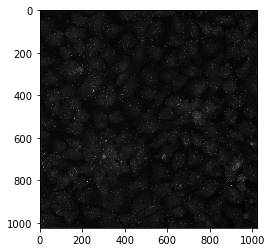

In [9]:
img = pil.open("Images/0710_CellHyb/EC20/FOV2_Cy3S.tif"); plt.imshow(img)
img_array = mh.stretch(np.array(img)); img.close()

<b> Intensity Info

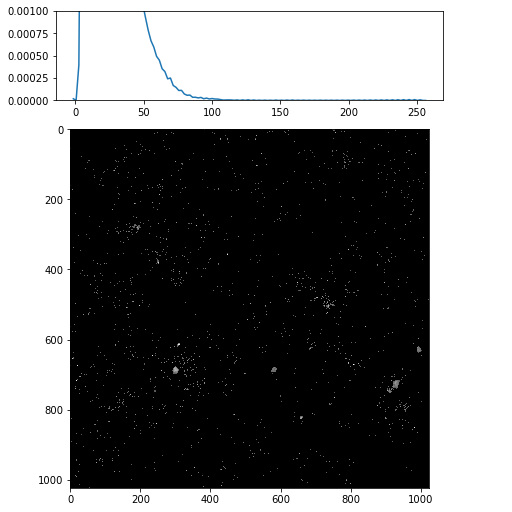

In [10]:
data_intensity = img_array.ravel()
fig = plt.figure(figsize=(7,7), constrained_layout = True); 
gs = GridSpec(5,5, figure=fig); ax = fig.add_subplot(gs[0,:-1])
sb.kdeplot(data_intensity,ax=ax); ax.set_ylim([0,0.001]); 
###
high_lim = 150; low_lim = 50
mask_thres = (high_lim>img_array)*(img_array>low_lim); thres_image = img_array*mask_thres; 
ax2 = fig.add_subplot(gs[1:,:-1]); ax2.imshow(thres_image)

<b> Image Processing / Thresholding

Otsu intensity: 22
Mean Intensity 17.09809112548828
Number of objects: 870


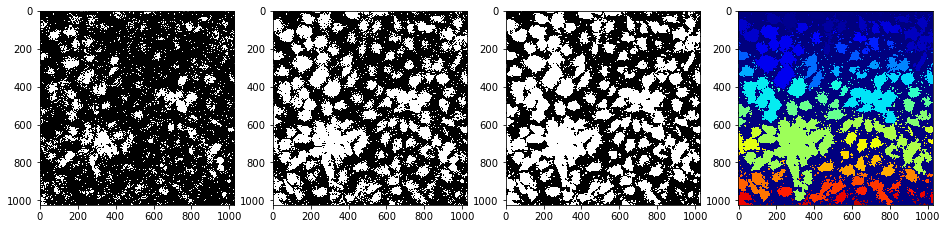

In [11]:
plt.figure(figsize=(16,5));
# Threshold 1 
T_otsu = mh.otsu(img_array); print('Otsu intensity:',T_otsu)
plt.subplot(141); plt.imshow(img_array > T_otsu)
# Threshold 2: mean
T_mean = img_array.mean(); print('Mean Intensity',T_mean)
plt.subplot(142); plt.imshow(img_array > T_mean)

# very noisy around the edges, but we can add some Gaussian blurring
gaussian_f = mh.gaussian_filter(img_array, 2.)
gT_mean = gaussian_f.mean(); bin_image = (gaussian_f > gT_mean)
plt.subplot(143); plt.imshow(bin_image)

# label the image in order to assign index to each component
labeled, nr_object = mh.label(bin_image); print('Number of objects:',nr_object)
plt.subplot(144); plt.imshow(labeled); plt.jet()

Ideal Parameter Determination

In [16]:
# Determine ideal sigma
@interact(sigma=(0.2, 5,0.1), dilate = (1, 5, 1))
def check_sigma(sigma, dilate):
    print('Sigma: ',sigma,'Dilate: ',dilate)
    gaussian_f = mh.gaussian_filter(img_array.astype('float'), sigma)
    local_maxima = mh.dilate(mh.regmax(mh.stretch(gaussian_f)), np.ones((dilate, dilate)))
    show_myimg(sk.color.label2rgb(local_maxima, img_array, alpha=0.7, bg_label=0, bg_color=None, colors=[(1, 0, 0)]))

interactive(children=(FloatSlider(value=2.5000000000000004, description='sigma', max=5.0, min=0.2), IntSlider(…

In [33]:
sigma = 1; dilate = 1; filename = 'MyMaxima_Example.tif'
local_maxima = mh.regmax(mh.stretch(gaussian_f))
pil.fromarray(mh.stretch(local_maxima*img_array)).save(filename)
#plt.imshow(pil.open(filename))

<b>Potential Pre-treat Maxima Calculations

In [270]:
from skimage.feature import peak_local_max

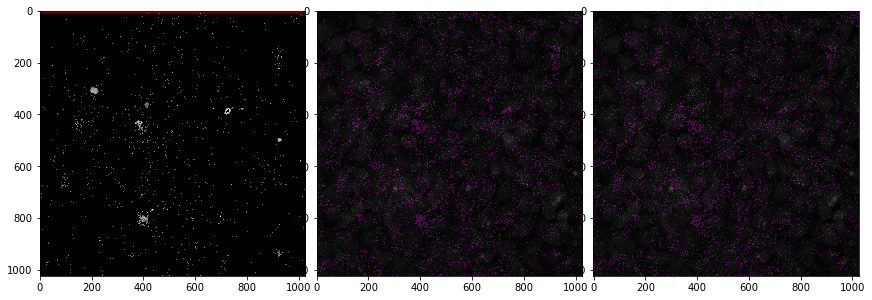

interactive(children=(IntSlider(value=6, description='h_log', max=15, min=-3), IntSlider(value=3, description=…

In [299]:
#1:  Get maxima positions
coord = peak_local_max(thres_image, min_distance=0);
peaks = np.zeros(img_array.shape); peaks[coord[:,0], coord[:,1]] = 1
fig = plt.figure(figsize=(12,4), constrained_layout = True); 
ax = fig.add_subplot(131); ax.plot(peaks, 'r.', markersize=.1); ax.imshow(thres_image);
#show_myimg(sk.color.label2rgb(peaks, thres_image, alpha=0.5, bg_label=0, bg_color=None, colors=[(1, 0, 0)]))
#2 mahotas
mh_maximas = mh.dilate(mh.regmax(thres_image), np.ones((4,4))); 
ax2 = fig.add_subplot(132); 
ax2.imshow(sk.color.label2rgb(mh_maximas, img_array, alpha=0.3, bg_label=0, colors=[(1, 0, 1)]))
#3 Skimage
local_maxima = sk.morphology.extrema.local_maxima(thres_image); 
label_maxima = mh.dilate(sk.measure.label(local_maxima) != 0, np.ones((4,4)))
ax3 = fig.add_subplot(133); ax3.imshow(sk.color.label2rgb(label_maxima, img_array, alpha=0.3, bg_label=0, colors=[(1, 0, 1)]))
#4  skimage : Adjust prominence (heigh difference)
@interact(h_log = (-3,15,1), dilate_factor = (1,5,1))
def OptimalProminence(h_log, dilate_factor):
    h = 10**(-h_log); print('h=',h)
    h_maxima = sk.morphology.extrema.h_maxima(thres_image, h_log); 
    label_h_maxima = sk.measure.label(h_maxima);
    overlay_h = sk.color.label2rgb(label_h_maxima, img_array, alpha=0.5, bg_label=0, bg_color=None, colors=[(1, 0, 0)])
    show_myimg(overlay_h,(5,5))
# for later
bin_image = label_maxima

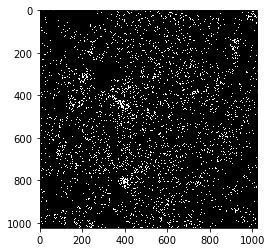

In [345]:
plt.imshow(label_maxima)

<b> Shape Selection

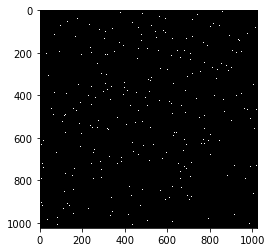

In [366]:
shape_index = sk.feature.shape_index(img_array)
circles = (1-shape_index)<=0.05   ## 1 is circle
plt.imshow(circles)

<b> imshowhow object based segmentation is not ideal for some

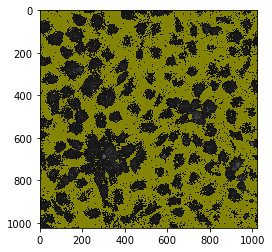

In [377]:
labeled_img, nr_object = mh.label(gaussian_f>gT_mean);
unique, counts = np.unique(labeled_img, return_counts=True); 
max_label = unique[np.argmax(counts)]; 
tissue_mask = (labeled_img == 0)
plt.imshow(sk.color.label2rgb(tissue_mask*img_array, img_array, alpha=0.5, 
           bg_label=0, bg_color=None, colors=[(1, 1, 0)]))

<b> Calculations

In [95]:
def sumAll(input):
    return sum(map(sum, input))

def CalculateSpotSNR(img_array, maxima):
    mean_maxima_intensity = sumAll(img_array*(maxima))/sumAll(maxima)
    mean_bg_intensity = sumAll(img_array*(maxima==False))/sumAll(maxima==False)
    return mean_maxima_intensity/mean_bg_intensity

def MeanofMask(img_array, mask):
    return sumAll(img_array*(mask))/sumAll(mask)

def CalculateSpotSNR_cell(img_array, maxima):
    return 

In [96]:
CalculateSpotSNR(img_array, label_maxima)

2.4314401108707808

<b> Used for Cell Count 

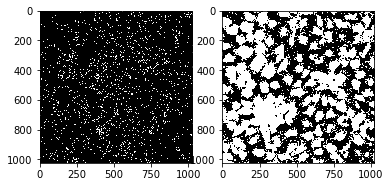

In [388]:
plt.subplot(121)
bin_image = label_maxima; plt.imshow(bin_image)
##
gaussian_f = mh.gaussian_filter(img_array, sigma = 2)
plt.subplot(122); bin_image2 = mh.dilate(gaussian_f>gaussian_f.mean(), np.ones((3,3))); 
plt.imshow(bin_image2)

In [ ]:
## Choose
bin_image = bin_image2
#
plt.figure(figsize=(20,8))
dist = mh.stretch(mh.distance(bin_image)); 
plt.subplot(141); plt.imshow(dist)
# Seed with the maximas
watershed = mh.cwatershed(dist, bin_image)
plt.subplot(142); plt.imshow(watershed);
# Remove background
watershed *= bin_image; 
plt.subplot(143); plt.imshow(watershed); _,nr_obj = mh.label(watershed); print('Count:', nr_obj)
# remove bordering
watershed2 = mh.labeled.remove_bordering(thres_image);
plt.subplot(144); plt.imshow(watershed2)

In [1]:
dist = mh.stretch(mh.distance(watershed)); 
maxima = mh.morph.regmax(dist, Bc=np.ones((9,9)))
spots,n_spots = mh.label(maxima, Bc=np.ones((9,9))); print('Counts:', n_spots)
plt.imshow(maxima);plt.imshow(dist!=0)

NameError: name 'mh' is not defined

In [142]:
surface = (dist.max() - dist)
areas = mh.cwatershed(surface, spots)
areas *= bin_image

<b> Spot size cut-off 

In [ ]:
sizes = mh.labeled.labeled_size(label_maxima*thres_image)
@interact(min_size = (0,4000,5))
def do_plot(min_size):
    print("filtering {}...".format(min_size))
    plt.imshow(mh.labeled.remove_regions_where(thres_image, sizes < min_size))

-------------------------------------------------------------------------------------